# User Study Analysis
This notebook reproduces the statistics and figures in Section 5 of the paper "Helping Programmers Find Relevant Code with Modular Slices".

In [25]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
from pymer4 import Lm, Lmer
from datetime import datetime
from matplotlib import rc
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

sns.set(
    style='whitegrid',
    palette='tab10', 
    
    ### Uncomment the code below to get the figures to look *exactly* like the paper.
    ### Requires LaTeX to be installed.
    
#     rc={
#         'font.family': 'serif', 
#         'font.serif': ['Linux Libertine O'],
#         'text.usetex': True,
#         'text.latex.preamble': r'\usepackage{libertine}\usepackage[libertine]{newtxmath}'
#     }
    )

In [26]:
TASKS = ['url', 'countries', 'cli']
TASK_LABELS = ['\\textsc{Url}', '\\textsc{Median}', '\\textsc{Command-Line}']
FLOWISTRY_LABEL = 'With \\textsc{Focus Mode}?'

SKIP = 2
RUST_LEVELS = [
    'I use Rust occassionally',
    'I use Rust regularly',
    'I use Rust for my job'
]

def parse_time(s):
    return datetime.strptime(s, '%H:%M:%S' if s.count(':') == 2 else '%M:%S')

results = []
for i, row in pd.read_json('../data/study-results-clean.json').iterrows():
    if i < SKIP or type(row['Participant']) != str:
        continue
        
    order = row['Order'].split(', ')
    nf = row['Non-Flowistry']
    for task in TASKS:
        index = order.index(task)
        prefix = f'Task {index + 1}'
        if type(row[prefix + ' start']) != str:
            continue           
            
        start, end = (parse_time(row[prefix + ' start']), parse_time(row[prefix + ' end']))
        duration = (end - start).seconds
        
        if task == 'url':
            t = row['Url - found pop']
            if t == 'no':
                found_pop = duration
            else:
                found_pop = (parse_time(t) - start).seconds
        else:
            found_pop = 0
            
        rust_level = RUST_LEVELS.index(row['Rust level'])
        
        results.append({
            'participant': i,
            'task': task,
            'experience': float(row['Years experience']),
            'rust_level': rust_level,
            'rust_expert': rust_level != 0,
            'completed': duration < 15 * 60,
            'time': min(duration, 15 * 60),
            'using_flowistry': task != nf,
            'found_pop': found_pop
        })
results = pd.DataFrame(results)
results['expert'] = results['experience'] >= results['experience'].median()
url = results[results.task == 'url']

# Methodology (Section 5.1)

## Average participant experience

In [27]:
participants = results.groupby('participant').apply(lambda df: df.iloc[0])
participants.experience.describe()

count    18.000000
mean      9.361111
std       7.839953
min       1.000000
25%       5.000000
50%       6.500000
75%       9.875000
max      30.000000
Name: experience, dtype: float64

# Results (Section 5.2)

## Figure 5-left

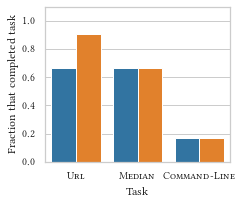

In [28]:
plt.figure(figsize=(3.5, 3))
df = results.groupby(['task', 'using_flowistry']) \
    .apply(lambda df: len(df[df.completed]) / len(df)) \
    .rename('completed_frac').reset_index()
ax = sns.barplot(data=df, x='task', y='completed_frac', hue='using_flowistry', order=TASKS)
ax.set_xticklabels(TASK_LABELS)
ax.set_xlabel('Task')
ax.set_ylabel('Fraction that completed task') 
ax.set_ylim(0, 1.1)
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('figures/task-completion-rate.pdf', bbox_inches='tight')

## Figure 5-right

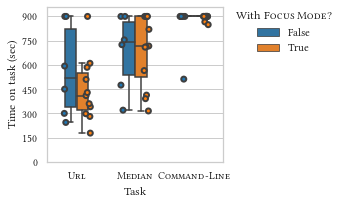

In [29]:
plt.figure(figsize=(5, 3))
common = dict(data=results, x='task', y='time', hue='using_flowistry', order=TASKS)
sns.stripplot(**common, dodge=True,  linewidth=2, jitter=True)
ax = sns.boxplot(**common, fliersize=0, width=0.4)
ax.set_xticklabels(TASK_LABELS)
ax.set_xlabel('Task')
ax.set_ylabel('Time on task (sec)')
ax.set_ylim(0, 16 * 60)
yticks =[0, 150, 300, 450, 600, 750, 900]
ax.set_yticks(yticks)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title=FLOWISTRY_LABEL, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
plt.tight_layout()
plt.savefig('figures/task-completion-time.pdf', bbox_inches='tight')

## Effect of Focus Mode on URL completion times

In [30]:
model = Lm('time ~ using_flowistry * experience', data=url)
model.fit()

Formula: time~using_flowistry*experience

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 17	 R^2: 0.393	 R^2_adj: 0.253

Log-likelihood: -111.982 	 AIC: 231.965	 BIC: 235.297

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,1011.900,598.455,1425.345,191.377,13,5.287,0.000,***
using_flowistry[T.True],-522.067,-983.235,-60.898,213.467,13,-2.446,0.029,*
experience,-75.617,-138.759,-12.475,29.227,13,-2.587,0.023,*
using_flowistry[T.True]:experience,71.462,6.619,136.304,30.015,13,2.381,0.033,*


## Difference in average time to first identifying code as buggy


In [31]:
means = url.groupby('using_flowistry').found_pop.mean()
means[False] - means[True]

212.96969696969694

## Effect of Focus Mode on  time to first identifying code as buggy

In [32]:
model = Lm('found_pop ~ using_flowistry * experience', data=url)
model.fit()

Formula: found_pop~using_flowistry*experience

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 17	 R^2: 0.438	 R^2_adj: 0.309

Log-likelihood: -113.628 	 AIC: 235.255	 BIC: 238.588

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,990.398,534.940,1445.856,210.824,13,4.698,0.000,***
using_flowistry[T.True],-664.775,-1172.806,-156.744,235.159,13,-2.827,0.014,*
experience,-81.476,-151.034,-11.918,32.197,13,-2.531,0.025,*
using_flowistry[T.True]:experience,78.631,7.199,150.063,33.065,13,2.378,0.033,*
